In [11]:
# %pip install ipynb
# %pip install face_recognition -i https://pypi.tuna.tsinghua.edu.cn/simple
# %pip uninstall opencv-python-headless -y 
# %pip install opencv-python --upgrade

In [12]:
# import notebook
from ipynb.fs.full.facial_similarity_checker import *
from ipynb.fs.full.image_landmark_extractor import *

# import the necessary packages
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [13]:
# helper function 
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif image.shape[-1] == 4:					
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()
    
def set_transparent(image):
	tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
	_ , alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
	b, g, r = cv2.split(image)
	rgba = [b, g, r, alpha]
	image = cv2.merge(rgba, 4)
	
	return image

In [37]:
class ImageRegistrar:
    def __init__(self, landmark_extractor):
        self.landmark_extractor = landmark_extractor
        self.matched_landmarks = None

    def align_images(self, image, reference_image, show=False):
        # extract the landmarks from the input image and reference image
        facial_landmarks = self.landmark_extractor.get_landmarks(image, reference_image, show=show)

        aligned_image = self.__align_image(image, reference_image, matches=facial_landmarks)

        # save the matched landmarks
        self.matched_landmarks = facial_landmarks[1]

        return aligned_image

    def __align_image(self, image, reference_image, matches):
        ptsA = np.zeros((len(matches[0]), 2), dtype="float")
        ptsB = np.zeros((len(matches[1]), 2), dtype="float")
        ptsA = np.array(matches[0])
        ptsB = np.array(matches[1])

        # print(f"ptsA: {ptsA}")
        # print(f"ptsB: {ptsB}")

        # compute the homography matrix between the two sets of matched
        # points
        (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=5.0)
        # print(f"H: {H}")
        
        # use the homography matrix to align the images
        (h, w) = reference_image.shape[:2]
        aligned = cv2.warpPerspective(image, H, (w, h))
        
        return aligned
    
    def __generate_face_routes(self):
        routes = []
        landmark_tuple = self.matched_landmarks
        
        for i in range(15, -1, -1):
            from_coordinate = landmark_tuple[i+1]
            to_coordinate = landmark_tuple[i]
            routes.append(from_coordinate)
        
        from_coordinate = landmark_tuple[0]
        to_coordinate = landmark_tuple[17]
        routes.append(from_coordinate)
        
        for i in range(17, 20):
            from_coordinate = landmark_tuple[i]
            to_coordinate = landmark_tuple[i+1]
            routes.append(from_coordinate)
        
        from_coordinate = landmark_tuple[19]
        to_coordinate = landmark_tuple[24]
        routes.append(from_coordinate)
        
        for i in range(24, 26):
            from_coordinate = landmark_tuple[i]
            to_coordinate = landmark_tuple[i+1]
            routes.append(from_coordinate)
        
        from_coordinate = landmark_tuple[26]
        to_coordinate = landmark_tuple[16]
        routes.append(from_coordinate)
        routes.append(to_coordinate)

        return routes
    
    def extract_face(self, image, target_image, show=False):
        if self.matched_landmarks is None:
            raise Exception("No matched landmarks found. Please call align_images first.")
 
        routes = self.__generate_face_routes()

        for i in range(0, len(routes)-1):
            from_coordinate = routes[i]
            to_coordinate = routes[i+1]
            image = cv2.line(image, from_coordinate, to_coordinate, (255, 255, 0), 1)
        
        mask = np.zeros((image.shape[0], image.shape[1]))
        mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
        mask = mask.astype(np.bool_)
 
        face_img = np.zeros_like(image)
        face_img[mask] = image[mask]
        
        # make background transparent
        face_img = set_transparent(face_img)
        
        ## set target image to black (only mask part is extracted)
        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2BGRA)
        target_image[mask, 3] = 0
        
        if show:
            plt_imshow("Extracted Face", face_img)
            plt_imshow("Target Image", target_image)
        
        output = target_image
        output[mask] = face_img[mask]
        
        return output
    

x: 524	y: 810	Size: (467,467)
x: 325	y: 513	Size: (860,860)
[INFO] loading images...
[INFO] aligning images...
!! No face detected !!


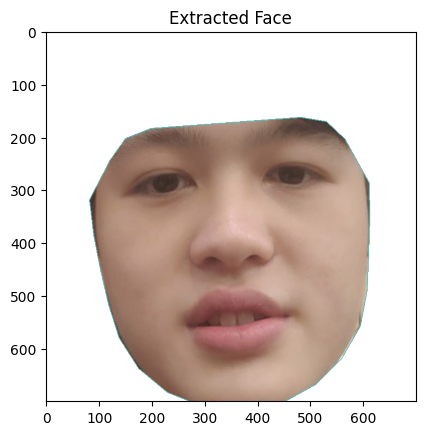

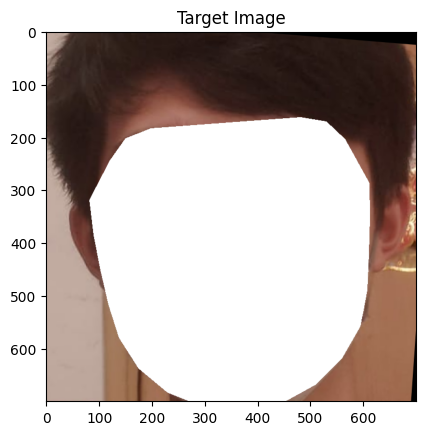

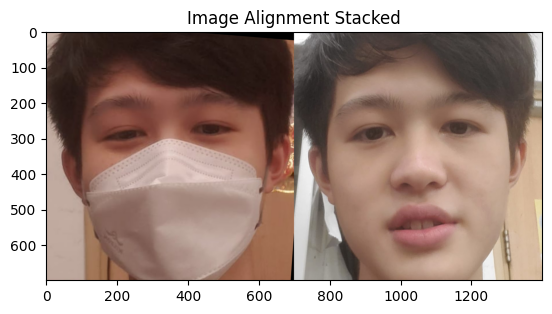

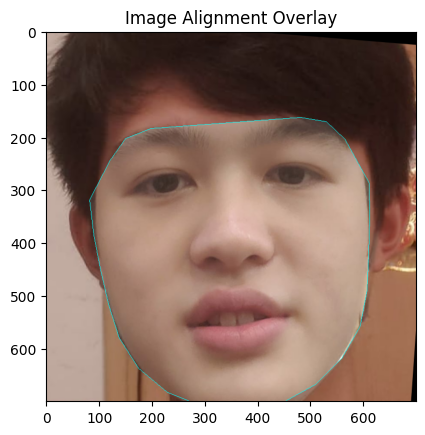

In [44]:
# construct the argument parser and parse the arguments
image_path = "img/me_with_mask.jpg"
template_path = "img/me_without_mask4.jpg"

checker = facial_similarity_checker()
checker.load_image(image_path, template_path)
checker.check_similarity()
# checker.show_result(show_detail=True)

area1, area2 = checker.get_facial_area()

# load the input image and template from disk
print("[INFO] loading images...")
image = cv2.imread(image_path)
template = cv2.imread(template_path)

image = image[area1.y:area1.y+area1.height, area1.x:area1.x+area1.width]
template = template[area2.y:area2.y+area2.height, area2.x:area2.x+area2.width]

# resize both the aligned and template images so we can easily
# visualize them on our screen
image = imutils.resize(image, width=700, height=700)
template = imutils.resize(template, width=700, height=700)

# align the images
image_registrar = ImageRegistrar(LandmarkExtractor("shape_predictor_68_face_landmarks.dat"))

print("[INFO] aligning images...")
aligned = image_registrar.align_images(image, template, show=False)

# our first output visualization of the image alignment will be a
# side-by-side comparison of the output aligned image and the
# template
stacked = np.hstack([aligned, template])

# our second image alignment visualization will be *overlaying* the
# aligned image on the template, that way we can obtain an idea of
# how good our image alignment is
output = image_registrar.extract_face(template, aligned, show=True)

# show the two output image alignment visualizations
plt_imshow("Image Alignment Stacked", stacked)
plt.show()

plt_imshow("Image Alignment Overlay", output)
plt.show()